### Import data

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

import pingouin as pg

import seaborn as sns
import matplotlib.pyplot as plt

from factor_analyzer import FactorAnalyzer

import sys
import os
sys.path.append(os.path.abspath(".."))  
sys.path.append(os.path.abspath("./src"))  

from src.data_processing import extract_features
from src.model import  self_calculate_bartlett_sphericity, filter_variables_by_kmo
from src.visualization import plot_factor_loadings



# Load dataset file with labels and features (FCC)
data_path = "../data/"

#dataset ='Automatic_Labeling_Kyoogu/'
dataset ='Dataset_1/'
#dataset ='Dataset_2/'

file = 'Labeled_Data_With_FCCs.xlsx'
df = pd.read_excel(data_path+dataset+file)

columns_to_remove = ['Month', 'Day', 'Hour', 'Length', 'Minute', 'Fmin', 'Fmax', 'View', 'Channel']  

# Remove columns from data frame
df = df.drop(columns_to_remove, axis=1, errors='ignore')
FS = 48000
df.head()



,File,Specie ID,Start,End,Fdom,FminVoc,FmaxVoc,FCC1,FCC2,FCC3,...,FCC14,FCC15,FCC16,FCC17,FCC18,FCC19,FCC20,FCC21,FCC22,FCC23
0,JAGUAS253_20121114_080107.wav,noise,0.243810,0.452789,0.000000,4091.308594,4414.306641,0.213900,0.754710,0.077064,...,-0.39418,0.084896,-0.412430,-0.087503,-0.382970,0.002611,-0.44035,-0.313180,0.416050,0.416550
1,JAGUAS253_20121114_080107.wav,noise,0.255420,0.429569,9344.569836,8484.082031,9603.808594,0.020643,1.221600,-0.113750,...,0.59106,0.212200,0.158320,-0.379770,-0.210170,0.108650,-0.44754,-0.807060,0.005677,0.354420
2,JAGUAS253_20121114_080107.wav,noise,0.255420,0.394739,7966.549876,7213.623047,8074.951172,0.077379,0.010165,-0.195200,...,0.53409,-0.202990,-0.779610,0.201410,0.174640,-0.002598,0.13216,-0.160550,0.396040,-0.649150
3,JAGUAS253_20121114_080107.wav,Coereba flaveola,0.464399,1.834376,7405.888291,5835.498047,10034.472656,1.723100,-0.721950,0.428380,...,-0.77551,0.274850,-0.049686,-0.045430,-0.017855,-0.051179,-0.18174,-0.032282,0.141720,0.053853
4,JAGUAS253_20121114_080107.wav,noise,0.557279,0.928798,3358.969607,3143.847656,5857.031250,2.095300,0.248520,-0.063928,...,0.26586,0.751570,0.121460,-0.256250,0.005781,0.271830,-0.23678,-0.057358,-0.100530,0.096016


## Manual extraction of Spectral Features and concatenation with previous features 

In [44]:
# Calculate features for each segment
# Write the path of the DB
audio_path = "../audios/"
if dataset == 'Dataset_2/':
    prefix = audio_path + dataset    
else:
    prefix = audio_path + 'Dataset_1/'   


spectral_features = []
for _, fila in df.iterrows():
    file_path = prefix + fila['File']
    #print(f"Processing file: {file_path}")
    features = extract_features(
        path=file_path,
        start=fila['Start'],
        end=fila['End'],
        freq_range=(fila['FminVoc'], fila['FmaxVoc'])
    )
    spectral_features.append(features)

# Convert the list of dictionaries into a DataFrame
df_spectral_features = pd.DataFrame(spectral_features)

# Crate a copy form the original DataFrame
df_copy = df.copy()

# Concatenate the new DataFrame of Spectral features with the copy of the original one. Index should be reset to avoid problems.
df_copy.reset_index(drop=True, inplace=True)
df_spectral_features.reset_index(drop=True, inplace=True)

df_allFeatures = pd.concat([df_copy, df_spectral_features], axis=1)
# Crear la nueva columna 'Length' como la resta de 'End' menos 'Start'
df_allFeatures['Length'] = df_allFeatures['End'] - df_allFeatures['Start']
df_allFeatures['DeltaFreq'] = df_allFeatures['FmaxVoc'] - df_allFeatures['FminVoc']

df_allFeatures

,File,Specie ID,Start,End,Fdom,FminVoc,FmaxVoc,FCC1,FCC2,FCC3,...,FCC19,FCC20,FCC21,FCC22,FCC23,spectral_centroid,bandwidth,spectral_flatness,Length,DeltaFreq
0,JAGUAS253_20121114_080107.wav,noise,0.243810,0.452789,0.000000,4091.308594,4414.306641,0.213900,0.754710,0.077064,...,0.002611,-0.440350,-0.313180,0.416050,0.416550,4296.966899,91.037389,0.687530,0.208980,322.998047
1,JAGUAS253_20121114_080107.wav,noise,0.255420,0.429569,9344.569836,8484.082031,9603.808594,0.020643,1.221600,-0.113750,...,0.108650,-0.447540,-0.807060,0.005677,0.354420,9064.762903,308.203387,0.716847,0.174150,1119.726562
2,JAGUAS253_20121114_080107.wav,noise,0.255420,0.394739,7966.549876,7213.623047,8074.951172,0.077379,0.010165,-0.195200,...,-0.002598,0.132160,-0.160550,0.396040,-0.649150,7642.463555,228.312395,0.720742,0.139320,861.328125
3,JAGUAS253_20121114_080107.wav,Coereba flaveola,0.464399,1.834376,7405.888291,5835.498047,10034.472656,1.723100,-0.721950,0.428380,...,-0.051179,-0.181740,-0.032282,0.141720,0.053853,7659.605368,975.161617,0.445569,1.369977,4198.974609
4,JAGUAS253_20121114_080107.wav,noise,0.557279,0.928798,3358.969607,3143.847656,5857.031250,2.095300,0.248520,-0.063928,...,0.271830,-0.236780,-0.057358,-0.100530,0.096016,4879.360701,723.329839,0.594829,0.371519,2713.183594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1063,JAGUAS253_20121114_234107.wav,noise,58.897415,58.990295,17269.439834,17075.830078,17894.091797,3.315100,-1.319000,-1.386700,...,0.072156,0.858240,0.090531,-0.014432,0.147600,17563.150016,217.629522,0.681334,0.092880,818.261719
1064,JAGUAS253_20121114_234107.wav,noise,58.897415,59.025125,6804.408155,6718.359375,7967.285156,0.360600,0.861810,0.807050,...,-0.088316,-0.021399,-0.114670,-0.184590,-0.605790,7185.535703,338.396962,0.605034,0.127710,1248.925781
1065,JAGUAS253_20121114_234107.wav,noise,59.129615,59.268934,17333.955412,17054.296875,18023.291016,1.583800,-0.038248,-1.652800,...,-0.027953,0.068764,-0.005296,-0.283920,0.303400,17574.669548,264.305789,0.694095,0.139320,968.994141
1066,JAGUAS253_20121114_234107.wav,noise,59.524354,59.628844,0.000000,17140.429688,17657.226562,2.894500,1.022200,-0.089280,...,0.100700,-1.962600,-0.362190,-0.153010,0.153210,17438.575935,150.828389,0.651208,0.104490,516.796875


### Remove noise labels

In [45]:
df_filtered = df_allFeatures[df_allFeatures['Specie ID'] != 'noise']
df_filtered = df_filtered.dropna(subset=['Specie ID'])
print(df_filtered['Specie ID'].value_counts())  

Specie ID
Hyloxalus                   157
Ramphocelus dimidiatus       38
Diasporus gularis            30
Call bird 2                  28
Call bird 1                  21
Basileuterus sp              12
Leptopogon superciliaris     11
Sing bird 1                  10
Coereba flaveola              9
Saltator maximus              7
Henicorhina leucosticta       6
Name: count, dtype: int64


### Divide features and labels, Scale Features

In [46]:
columns_to_remove = ['File','Specie ID','Specie', 'Taxon', 'sonotype', 'Peak Freq']  
df_only_features = df_filtered.drop(columns_to_remove, axis=1, errors='ignore') #Dataframe without labels, only features

# Standardize the features
scaler = StandardScaler()
only_features_scaled = scaler.fit_transform(df_only_features)


### Check Multinormality & Correlation Matrix with spearman

HZResults(hz=1316, pval=0.0, normal=False)


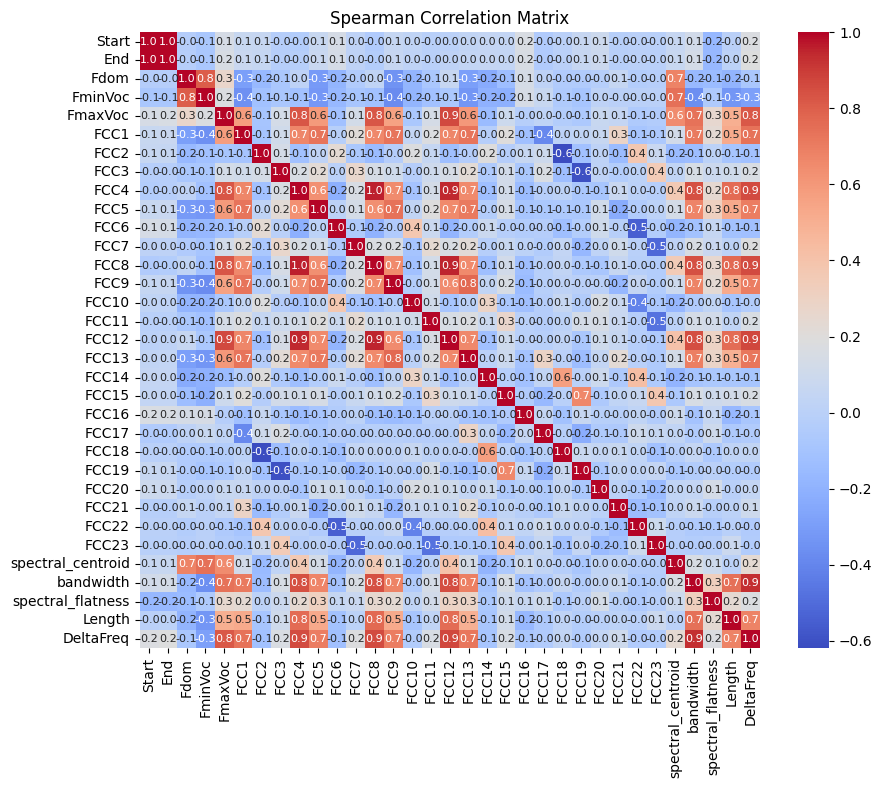

In [47]:
#Normality Test
normality_test = pg.multivariate_normality(only_features_scaled, alpha=0.05)
print(normality_test)

# Convert back to a DataFrame and assign column names
df_only_features_scaled = pd.DataFrame(only_features_scaled, columns=df_only_features.columns)
correlation_matrix = df_only_features_scaled.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f", annot_kws={"size": 8})

plt.title('Spearman Correlation Matrix')
plt.show()

## Remove variables with high correlation


In [48]:
# Define the threshold for high correlation
threshold = 0.85

# Create a mask for the upper triangle of the matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Find the variables with high correlation
high_corr_vars = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            high_corr_vars.add(colname)

#high_corr_vars.add('FCC13')
print("Variables with high correlation:", high_corr_vars)

df_only_features_scaled = df_only_features_scaled.drop(columns=high_corr_vars, errors='ignore')



Variables with high correlation: {'FCC8', 'End', 'DeltaFreq', 'FCC12'}


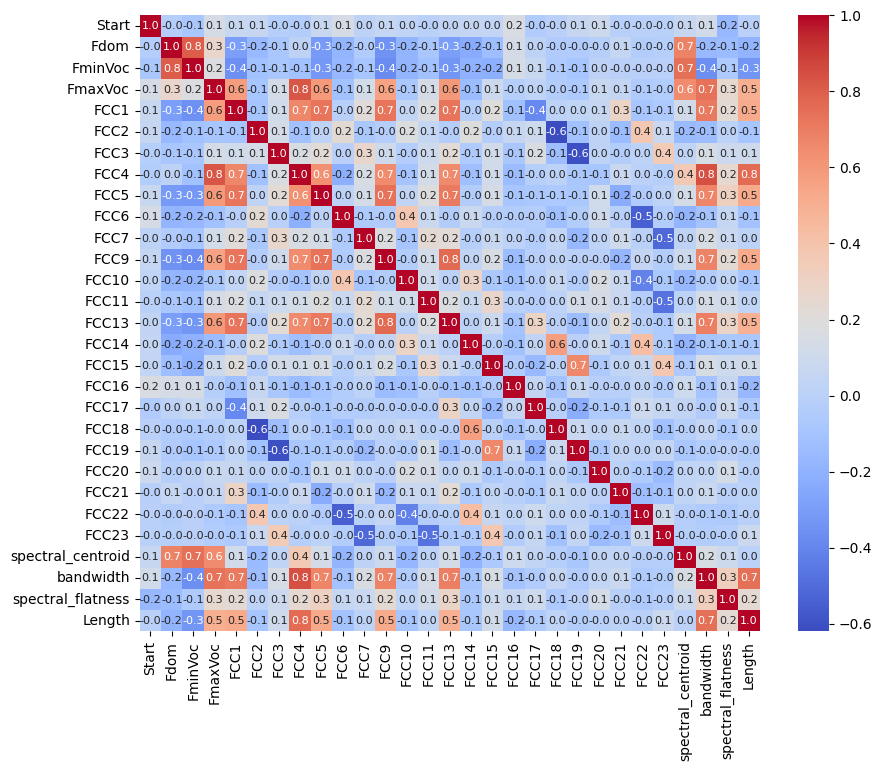

In [49]:
# Display the correlation matrix with a heatmap
plt.figure(figsize=(10, 8))  # Set the size of the figure

# Calculate the correlation matrix using Spearman's method
correlation_matrix_reduced = df_only_features_scaled.corr(method='spearman')

# Generate the heatmap
sns.heatmap(correlation_matrix_reduced, annot=True, cmap='coolwarm', fmt=".1f", annot_kws={"size": 8})

# Show the plot
plt.show()

### Bartlett Test

In [50]:
chi_square_value, p_value = self_calculate_bartlett_sphericity(df_only_features_scaled)
print(f"Results of the Bartlett Test are: Chi-square: {chi_square_value}, p-value: {p_value}")

Results of the Bartlett Test are: Chi-square: 8638.258452476915, p-value: 0.0


### KMO Test

KMO: 0.5448259303590495
Variables with value less than 0.4 are removed.
Detecting variables with low KMO...


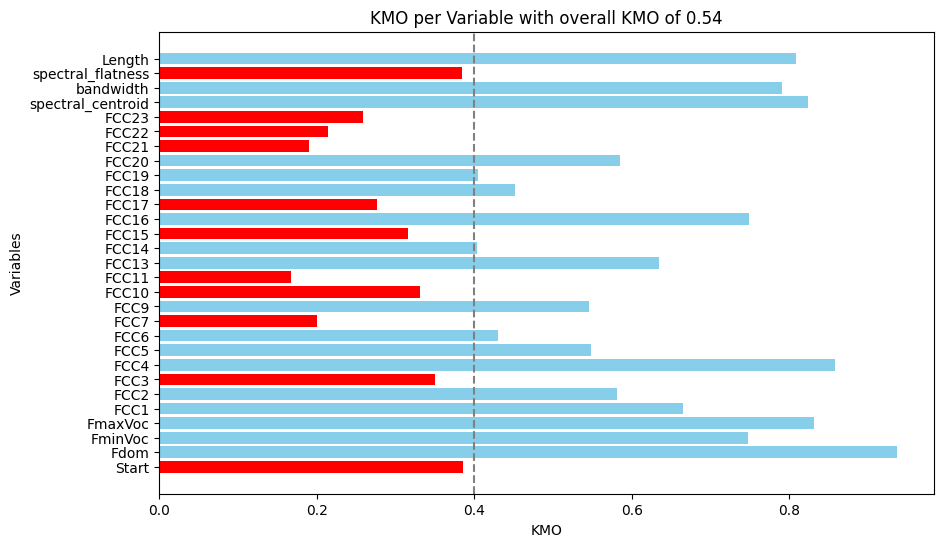

Calculating the new KMO...
The new KMO value after removing variables is: 0.7744881279485725


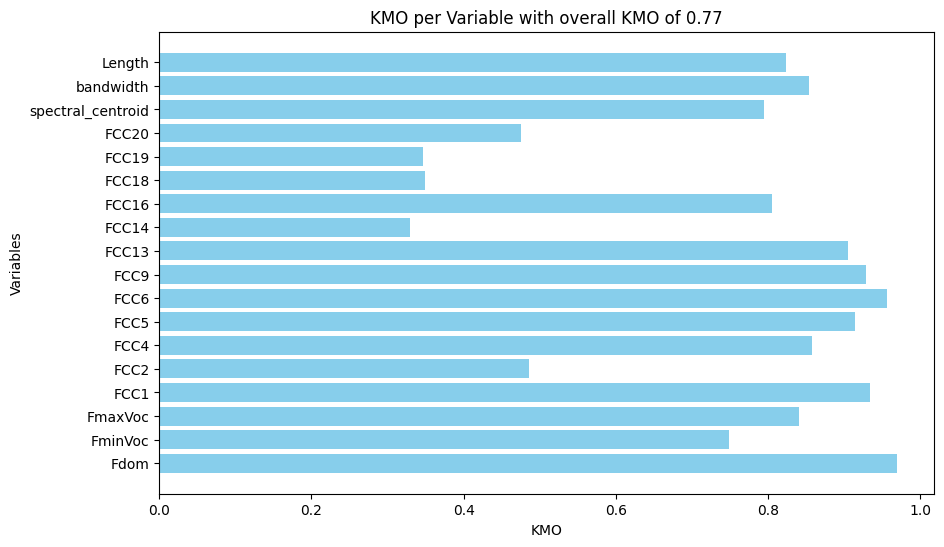

The final KMO value is: 0.7744881279485725
The removed variables are: 
              Variable
0               Start
1                FCC3
2                FCC7
3               FCC10
4               FCC11
5               FCC15
6               FCC17
7               FCC21
8               FCC22
9               FCC23
10  spectral_flatness


In [51]:
df_filtered_afterKMO, variables_to_remove = filter_variables_by_kmo(df_only_features_scaled, limit = 0.4)

## Factor Analysis with Varimax Rotation

In [52]:
correlation_matrix_afterKMO = df_filtered_afterKMO.corr(method='spearman')
# Factor Analysis with varimax rotation 
fa1 = FactorAnalyzer(n_factors=3, rotation='varimax', method="minres", is_corr_matrix=True)

# Fit the FactorAnalyzer model on the correlation matrix after KMO filtering
fa1.fit(correlation_matrix_afterKMO)

# Obtain loadings
loadings = fa1.loadings_

# Create a DataFrame with the factor loadings
loadings_df = pd.DataFrame(loadings, columns=[f'Factor{i+1}' for i in range(loadings.shape[1])], index=df_filtered_afterKMO.columns)

print("Factor loadings:")
print(loadings_df)


Factor loadings:
                    Factor1   Factor2   Factor3
Fdom              -0.270525  0.834483 -0.129909
FminVoc           -0.379745  0.842446 -0.156196
FmaxVoc            0.760198  0.533209 -0.123852
FCC1               0.828486 -0.064610  0.017004
FCC2              -0.081004 -0.292544 -0.483407
FCC4               0.876004  0.278787 -0.023838
FCC5               0.813177 -0.078922 -0.086034
FCC6              -0.078183 -0.260822 -0.122859
FCC9               0.826881 -0.109545  0.018226
FCC13              0.820673 -0.059119 -0.018558
FCC14             -0.048501 -0.224968  0.406455
FCC16             -0.146827  0.102507 -0.134604
FCC18              0.012740  0.117288  1.036345
FCC19             -0.052882 -0.054574  0.101669
FCC20              0.029888 -0.009058  0.023345
spectral_centroid  0.172249  0.866677 -0.138016
bandwidth          0.899233  0.059117  0.032659
Length             0.709712 -0.024311  0.033834


### Create Latent Variables

In [53]:
# Assign each variable to the factor with the highest loading
assignment = {}
for variable in loadings_df.index:
    max_loading_factor = loadings_df.loc[variable].abs().idxmax()
    max_loading_value = loadings_df.loc[variable, max_loading_factor]
    if round(abs(max_loading_value), 1) >= 0.35:
        assignment[variable] = (max_loading_factor, round(max_loading_value, 1))

# Create the latent variables (factors)
latent_variables = {f'Factor{i+1}': np.zeros(len(df_filtered_afterKMO)) for i in range(loadings.shape[1])}

for variable, (factor, weight) in assignment.items():
    latent_variables[factor] += weight * df_only_features[variable]

# Convert to DataFrame
df_latent = pd.DataFrame(latent_variables)

print("Latent Variables (factors):")
print(df_latent.head())


Latent Variables (factors):
        Factor1       Factor2   Factor3
3   8912.236728  17486.753902  0.032916
8   4786.574522   8691.426587  0.589535
11  3586.205553   7209.557240 -0.932632
18  4811.590502   9036.150427 -0.129832
19  3604.450814  10467.255379 -0.396627


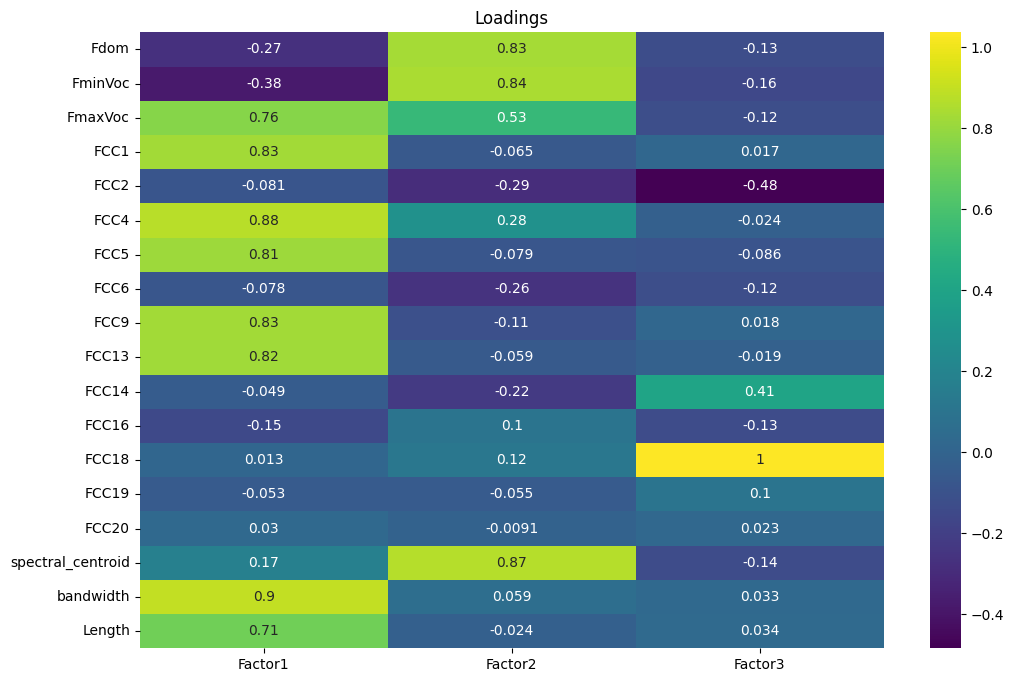

In [54]:
# Ploting the loadings
plt.figure(figsize=(12, 8))
sns.heatmap(loadings_df, annot=True, cmap='viridis')
plt.title('Loadings')
plt.show()

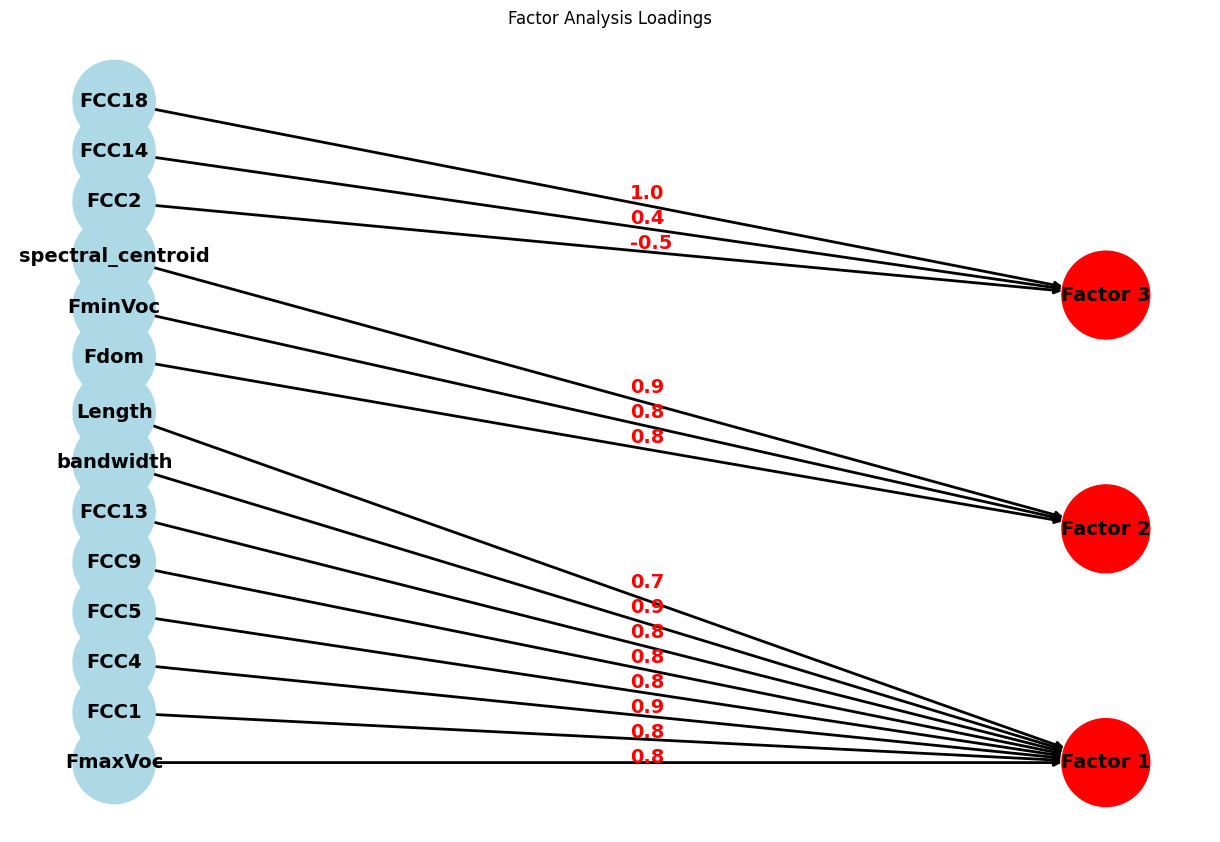

In [55]:
plot_factor_loadings(loadings_df)

### Create new dataset only with the latent variables and removed variables from KMO.

In [56]:
# Filtrar variables de variables_to_remove que no empiezan con "FCC"
variables_to_add = variables_to_remove[~variables_to_remove['Variable'].str.startswith('FCC')]

# Seleccionar las columnas correspondientes en df_only_features
Removed_Variables = df_only_features[variables_to_add['Variable']]

# Concatenar las columnas filtradas a df_reduced
df_reduced2 = pd.concat([df_latent, Removed_Variables], axis=1)
df_reduced2['Specie_ID'] = df_filtered['Specie ID']

# Verificar el resultado
print("Combined DataFrame:")
print(df_reduced2.head())

outputfile = 'reduced_dataframe_FA2.xlsx'
df_reduced2.to_excel(data_path+dataset+outputfile,index=True)


Combined DataFrame:
        Factor1       Factor2   Factor3     Start  spectral_flatness  \
3   8912.236728  17486.753902  0.032916  0.464399           0.445569   
8   4786.574522   8691.426587  0.589535  2.159456           0.486660   
11  3586.205553   7209.557240 -0.932632  3.842902           0.649695   
18  4811.590502   9036.150427 -0.129832  6.838277           0.434054   
19  3604.450814  10467.255379 -0.396627  7.372336           0.411317   

                   Specie_ID  
3           Coereba flaveola  
8   Leptopogon superciliaris  
11                 Hyloxalus  
18  Leptopogon superciliaris  
19                 Hyloxalus  
